# **Data Classification**

## Project Overview
This notebook focuses on predicting the risk of heart disease using patient data. The dataset includes features such as age, gender, blood pressure, cholesterol levels, and other clinical measurements.

The goal is to build machine learning models that can:
- Predict whether a patient is at risk of heart disease.
- Identify the most important risk factors contributing to the prediction.
- Provide interpretable results for medical insights.

## **Importing Library**

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split ,RandomizedSearchCV ,cross_val_score , GridSearchCV
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.ensemble import RandomForestClassifier , StackingClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score , classification_report,accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

import warnings
warnings.filterwarnings('ignore')

# **Exploratory Data Analysis**

### **Reading data**

In [3]:
Heart_train = pd.read_csv('/kaggle/input/heart-dataset/heart.csv')

In [4]:
Heart_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [5]:
Heart_train.shape

(918, 12)

In [6]:
Heart_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
Heart_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


**Data Visualization:**

To show corrleation between features:

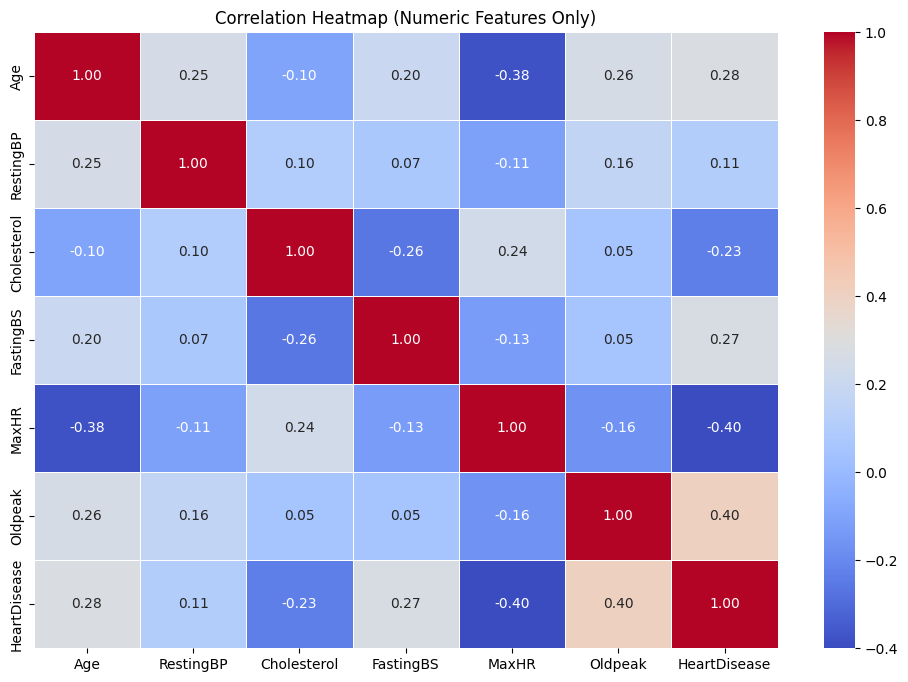

In [8]:
# to calculate coorelation

# take only numerical columns
numeric_df = Heart_train.select_dtypes(include=['int64', 'float64'])

corr = numeric_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()

To show features by Histplot:

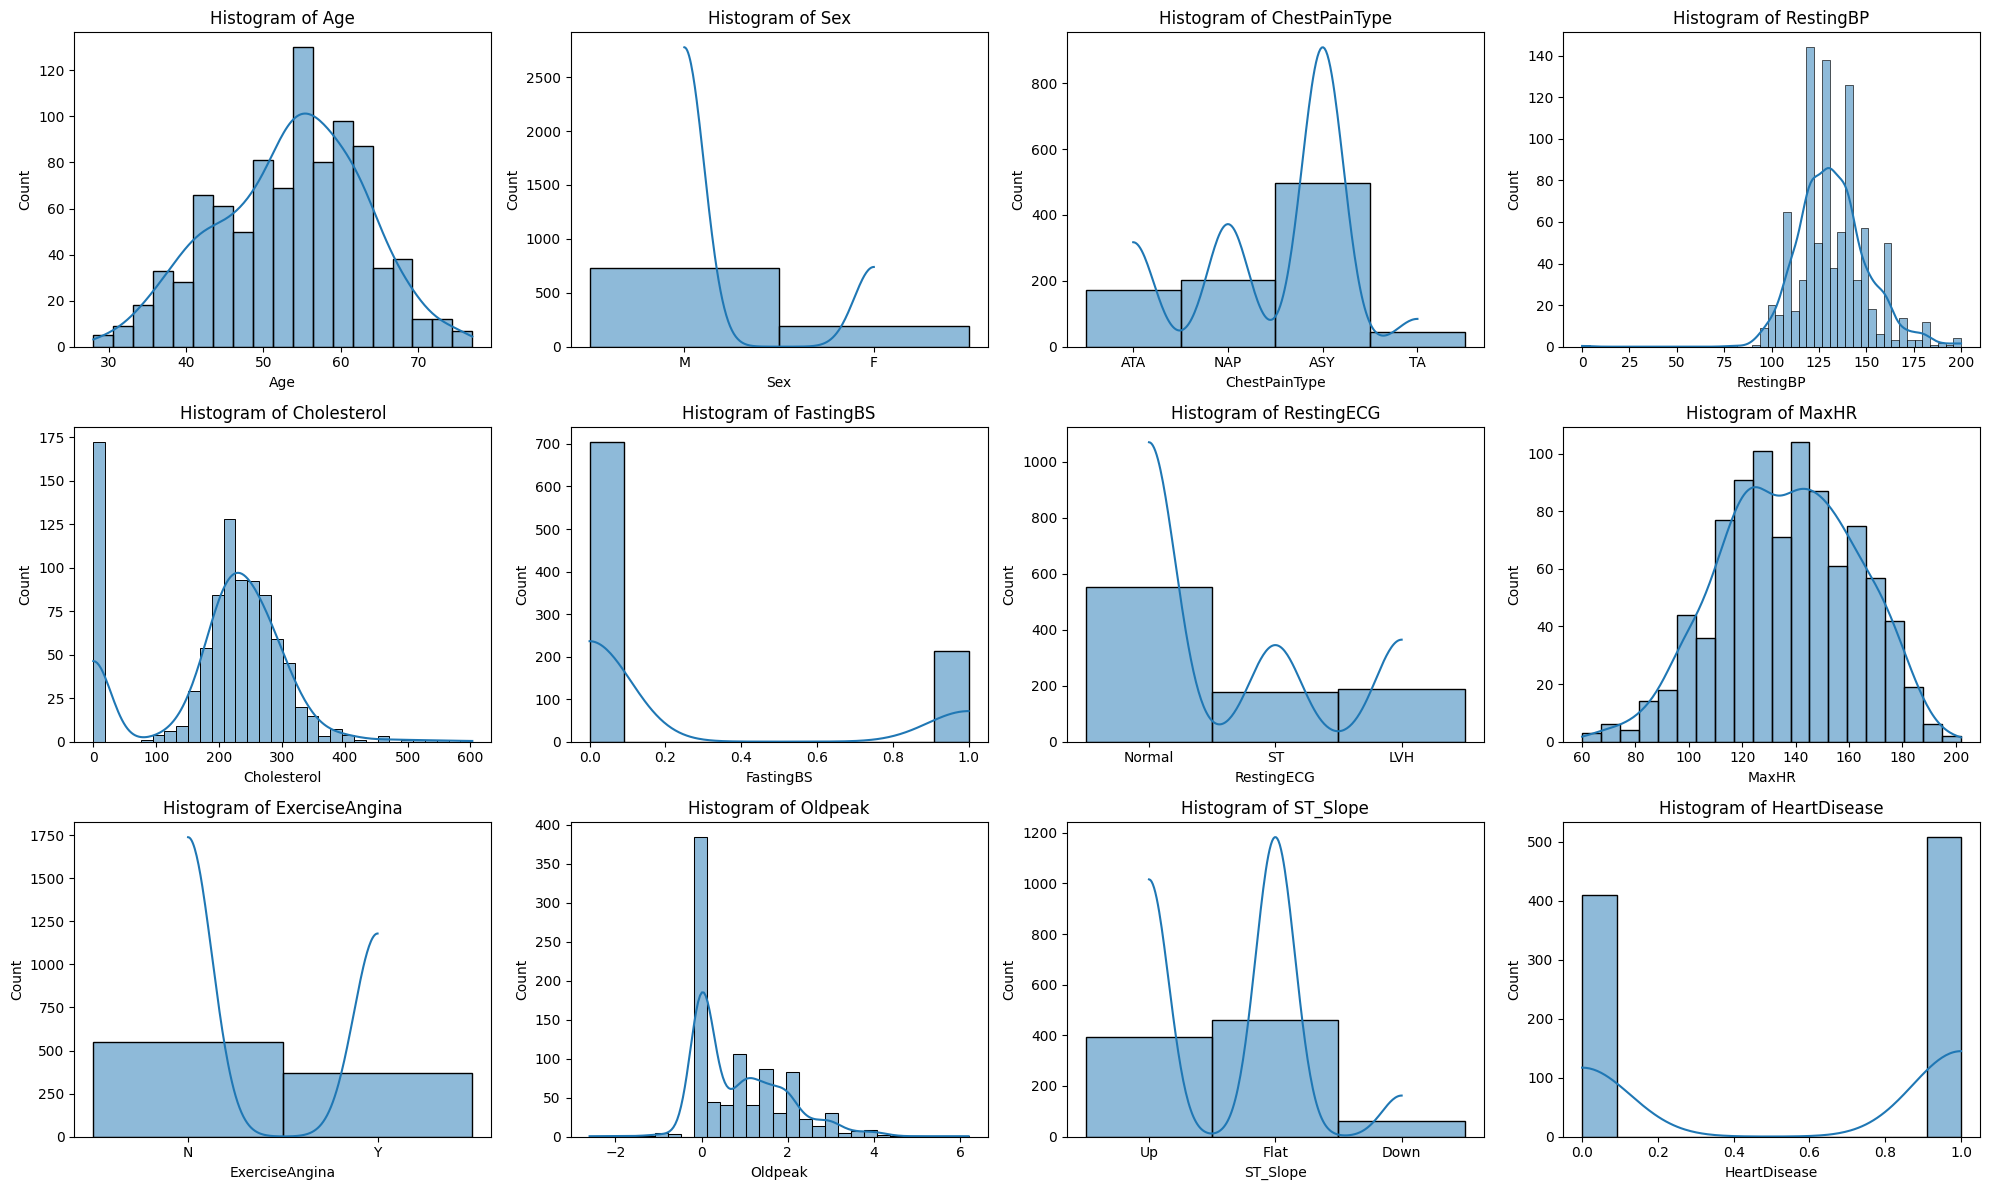

In [9]:
cols = Heart_train.columns
n = len(cols)

# numbers of columns at row
cols_per_row = 4
rows = -(-n // cols_per_row)   # ceil(n/5)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(5*cols_per_row, 4*rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    try:
        sns.histplot(Heart_train[col], kde=True, ax=axes[i])
        axes[i].set_title(f"Histogram of {col}")
    except Exception as e:
        axes[i].set_visible(False)  # if columns not a number not visible

# remove empty values
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## **Data Cleaning**

### **Nulls**

To check if found any Nulls at data:

In [10]:
Heart_train.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There is no Nulls at our data

### **Outliers**

Lets check if found outliers at our data:

For visualization outliers at non objected features we use this code:

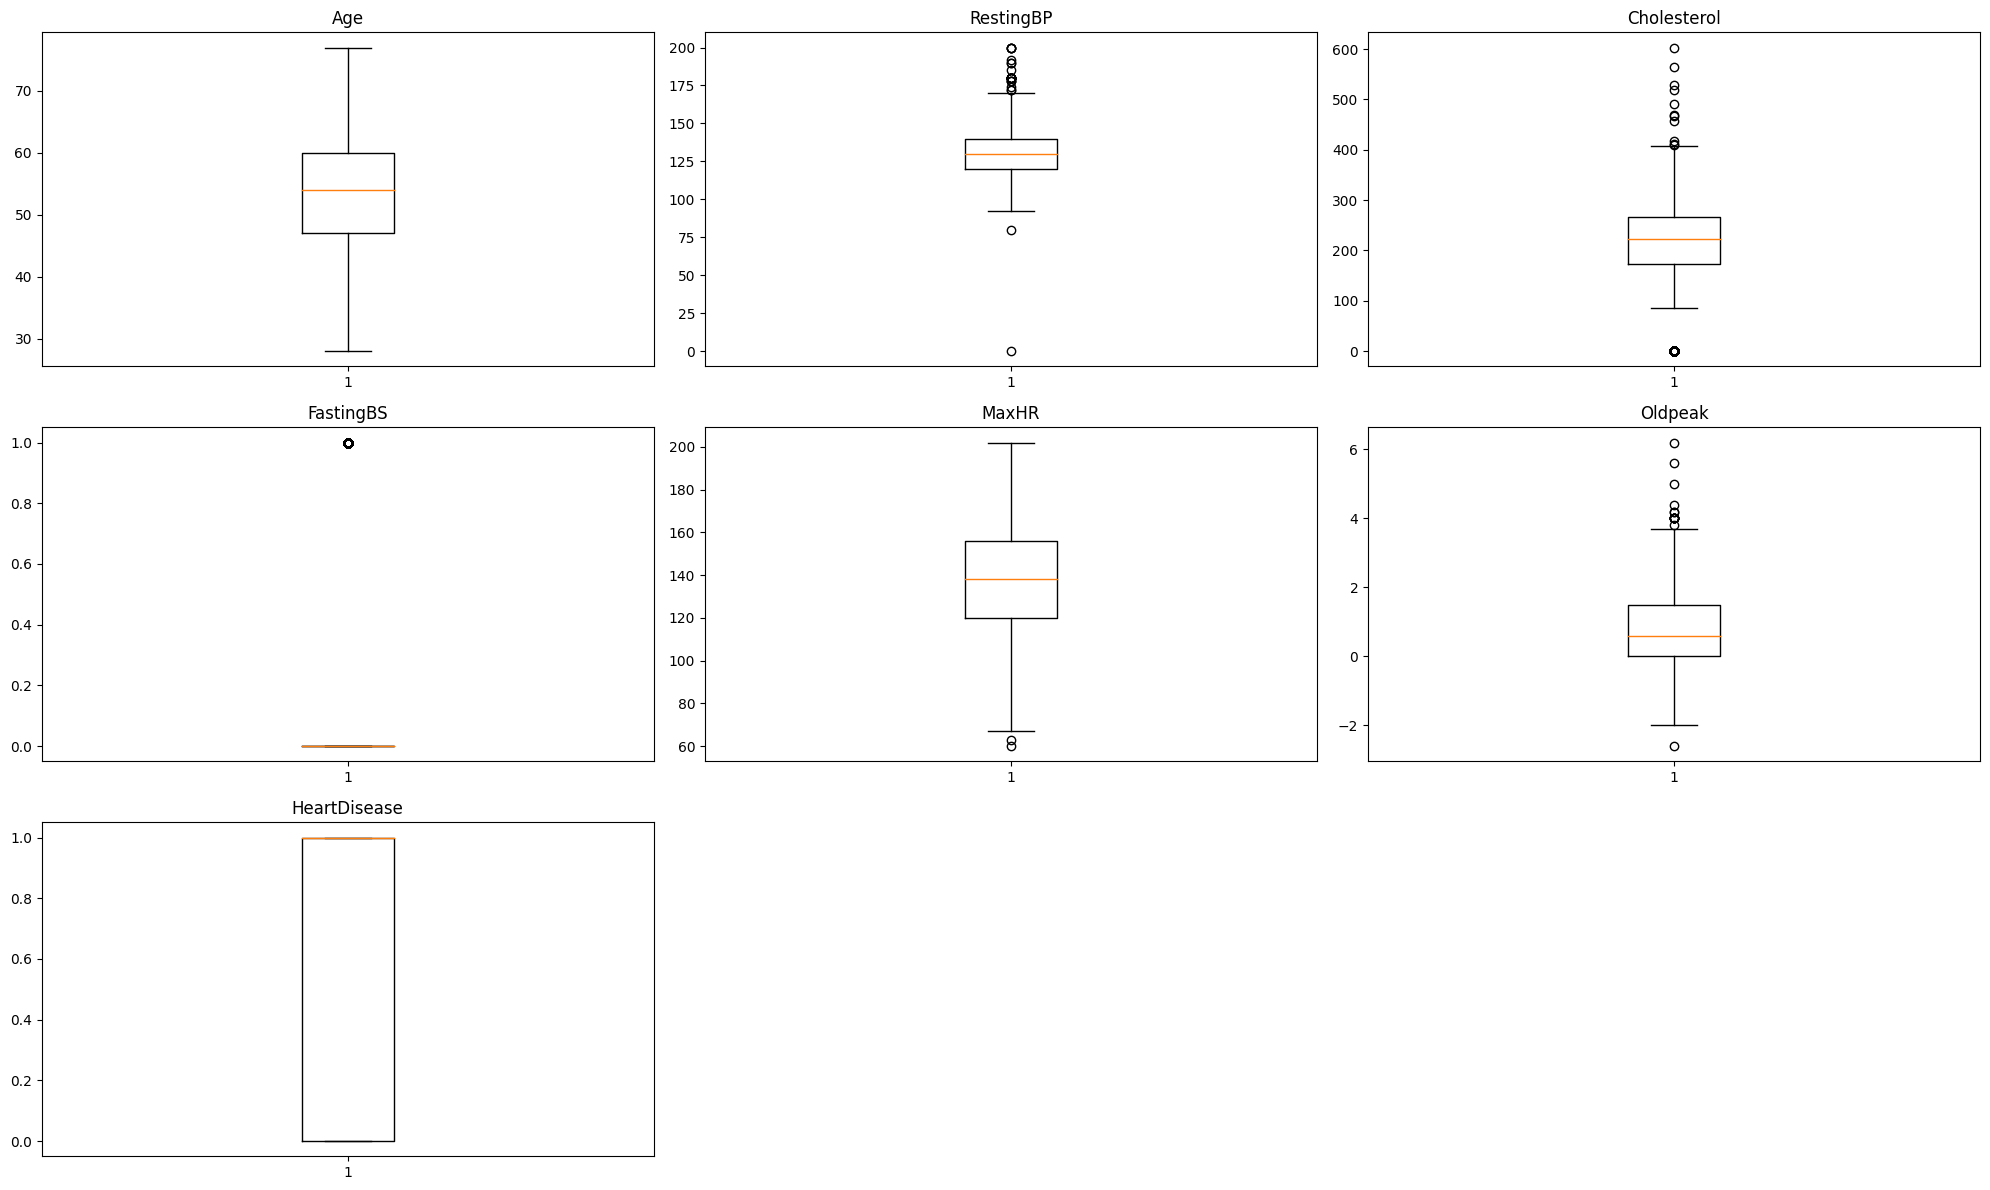

In [11]:
# To extract only numerical columns
num_cols = Heart_train.select_dtypes(include=['number']).columns

# Number of rows and columns
n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))

axes = axes.flatten()  # Turn array to list to easy use

for i, col in enumerate(num_cols):
    axes[i].boxplot(Heart_train[col])
    axes[i].set_title(col)

# Remove empty value
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [12]:
Heart_train.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

For remove outliers from **RestingBP**

To know min and max value at **RestingBP** feature:

In [13]:
Heart_train['RestingBP'].min(),Heart_train['RestingBP'].max()

(0, 200)

In [14]:
x = 'RestingBP'
q75,q25 = np.percentile(Heart_train.loc[:,x],[75,25])
IQR = q75 - q25
Upper = q75 + (3 * IQR)
Lower = q25 - (2 * IQR)
Heart_train.loc[Heart_train[x] <Lower ,x] = np.nan
Heart_train.loc[Heart_train[x] > Upper,x] = np.nan

Visualization after remove outliers by Boxplot

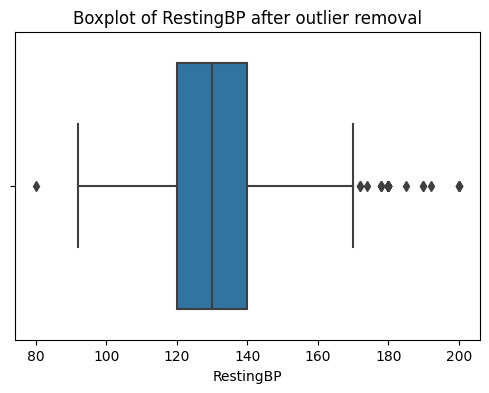

In [15]:
plt.figure(figsize=(6,4))
sns.boxplot(x=Heart_train[x])
plt.title(f'Boxplot of {x} after outlier removal')
plt.show()

At **RestingBP** we remove incorrect values becuse RestingBP at normal from 120-80 and above 120 is ubnormal and lower 80 is ubnormal too but there is no diastolic lower than 40 and systolic higher than 200 so we chosen this range at RestingBP feature

To check min and max values after removing outliers:

In [16]:
Heart_train['RestingBP'].min(),Heart_train['RestingBP'].max()

(80.0, 200.0)

For remove outliers from **Cholesterol**

To know min and max value at **Cholesterol** feature:

In [17]:
Heart_train['Cholesterol'].min(),Heart_train['Cholesterol'].max()

(0, 603)

In [18]:
x = 'Cholesterol'
q75,q25 = np.percentile(Heart_train.loc[:,x],[75,25])
IQR = q75 - q25
Upper = q75 + (1.2 * IQR)
Lower = q25 - (1 * IQR)
Heart_train.loc[Heart_train[x] <Lower ,x] = np.nan
Heart_train.loc[Heart_train[x] > Upper,x] = np.nan

Visualization after remove outliers by Boxplot

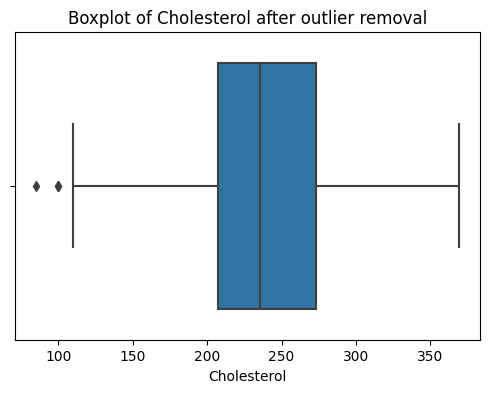

In [19]:
plt.figure(figsize=(6,4))
sns.boxplot(x=Heart_train['Cholesterol'])
plt.title(f'Boxplot of {x} after outlier removal')
plt.show()

At **Cholesterol** level lower cholestrol not affected badly at health but rang is from 100-200 so lower than 100 is ubnormal and more than 240 is ubnormal and danger so we chosen range 85-369 to collect all ranges

To check min and max values after removing outliers:

In [20]:
Heart_train['Cholesterol'].min(),Heart_train['Cholesterol'].max()

(85.0, 369.0)

For remove outliers from **Oldpeak**

To know min and max value at **Oldpeak** feature:

In [21]:
Heart_train['Oldpeak'].min(),Heart_train['Oldpeak'].max()

(-2.6, 6.2)

In [22]:
x = 'Oldpeak'
q75,q25 = np.percentile(Heart_train.loc[:,x],[75,25])
IQR = q75 - q25
Upper = q75 + (1.7 * IQR)
Lower = q25 - (.01 * IQR)
Heart_train.loc[Heart_train[x] <Lower ,x] = np.nan
Heart_train.loc[Heart_train[x] > Upper,x] = np.nan

Visualization after remove outliers by Boxplot

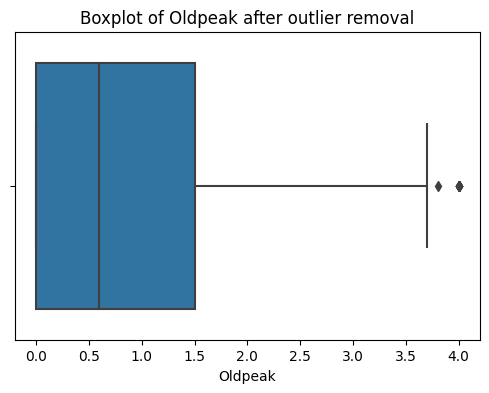

In [23]:
plt.figure(figsize=(6,4))
sns.boxplot(x=Heart_train['Oldpeak'])
plt.title(f'Boxplot of {x} after outlier removal')
plt.show()

At **Oldpeak** feature there is no values under zero medically its wrong so value range from 0 mm-4 mm so we remove incorrect values

To check min and max values after removing outliers:

In [24]:
Heart_train['Oldpeak'].min(),Heart_train['Oldpeak'].max()

(0.0, 4.0)

for replacement nan values by mean after removing outliers

In [25]:
columns = ['Oldpeak','Cholesterol','RestingBP']
for col in columns:
  mean_value = Heart_train[col].mean()
  Heart_train[col].fillna(mean_value, inplace=True)

To know if data of Output feature **HeartDisease** is balance or not :

In [26]:
Heart_train['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

 Output feature HeartDisease appeare balanced data

## **Feature Engneering & Processing**

In [27]:
objecte_columns = ['Sex','ChestPainType','RestingECG','ExerciseAngina','ST_Slope']
for col in objecte_columns:
  print(f'{col} :{Heart_train[col].unique()}')

Sex :['M' 'F']
ChestPainType :['ATA' 'NAP' 'ASY' 'TA']
RestingECG :['Normal' 'ST' 'LVH']
ExerciseAngina :['N' 'Y']
ST_Slope :['Up' 'Flat' 'Down']


we use **Lable encoder** to turn categorical features (Sex,ExerciseAngina) to numbers that can make model deal with in training and prediction

In [28]:
Label_Encoder = LabelEncoder()

In [29]:
for col in ['Sex', 'ExerciseAngina']:
    Heart_train[col] = Label_Encoder.fit_transform(Heart_train[col])

We use **OneHotEncoder** to turn other categorical features to numerical features:

In [30]:
Heart_train = pd.get_dummies(Heart_train, columns=['ChestPainType', 'RestingECG','ST_Slope'], drop_first=True)

So we check our data after featureextraction we do

In [31]:
Heart_train.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140.0,289.0,0,172,0,0.0,0,True,False,False,True,False,False,True
1,49,0,160.0,180.0,0,156,0,1.0,1,False,True,False,True,False,True,False
2,37,1,130.0,283.0,0,98,0,0.0,0,True,False,False,False,True,False,True
3,48,0,138.0,214.0,0,108,1,1.5,1,False,False,False,True,False,True,False
4,54,1,150.0,195.0,0,122,0,0.0,0,False,True,False,True,False,False,True


In [32]:
Heart_train.shape

(918, 16)

### **Splitting data**

In [33]:
X = Heart_train.drop(['HeartDisease'],axis=1)
y = Heart_train['HeartDisease']

In [34]:
#Splitting data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44, shuffle =True)

#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (688, 15)
X_test shape is  (230, 15)
y_train shape is  (688,)
y_test shape is  (230,)


## **Model training**

We Applying **RandomForestClassifier Model**

In [35]:
RandomForestClassifierModel = RandomForestClassifier(criterion = 'gini',n_estimators=1000,max_depth=2,random_state=33) #criterion can be also : entropy
RandomForestClassifierModel.fit(X_train, y_train)

#Calculating Details
print('RandomForestClassifierModel Train Score is : ' , RandomForestClassifierModel.score(X_train, y_train))
print('RandomForestClassifierModel Test Score is : ' , RandomForestClassifierModel.score(X_test, y_test))
print('RandomForestClassifierModel features importances are : ' , RandomForestClassifierModel.feature_importances_)
print('----------------------------------------------------')

#Calculating Prediction
y_pred = RandomForestClassifierModel.predict(X_test)
y_pred_prob = RandomForestClassifierModel.predict_proba(X_test)
print('Predicted Value for RandomForestClassifierModel is : ' , y_pred[:10])
print('Prediction Probabilities Value for RandomForestClassifierModel is : ' , y_pred_prob[:10])

RandomForestClassifierModel Train Score is :  0.8430232558139535
RandomForestClassifierModel Test Score is :  0.8173913043478261
RandomForestClassifierModel features importances are :  [0.02921393 0.03771382 0.00448796 0.01227768 0.02548333 0.06808407
 0.13954404 0.11673957 0.09443156 0.01662768 0.00070905 0.00087097
 0.00041519 0.18134584 0.27205531]
----------------------------------------------------
Predicted Value for RandomForestClassifierModel is :  [0 0 1 1 0 0 1 1 1 1]
Prediction Probabilities Value for RandomForestClassifierModel is :  [[0.6675454  0.3324546 ]
 [0.60820623 0.39179377]
 [0.16323815 0.83676185]
 [0.18633203 0.81366797]
 [0.66520902 0.33479098]
 [0.62948451 0.37051549]
 [0.16483529 0.83516471]
 [0.16539456 0.83460544]
 [0.40542908 0.59457092]
 [0.22474926 0.77525074]]


### **Model Evaluation**

To evaluate model if predicted values is near to real values:

To show **Cross-Validation Score**

In [36]:
cv_scores = cross_val_score(RandomForestClassifierModel, X, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.94021739 0.82065217 0.86956522 0.78688525 0.71038251]
Mean CV Score: 0.8255405084343075


To show **Classification Report** (precision, recall, f1-score)

In [37]:
y_pred = RandomForestClassifierModel.predict(X_test)

report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
print(df_report)

              precision    recall  f1-score     support
0              0.842105  0.747664  0.792079  107.000000
1              0.800000  0.878049  0.837209  123.000000
accuracy       0.817391  0.817391  0.817391    0.817391
macro avg      0.821053  0.812856  0.814644  230.000000
weighted avg   0.819588  0.817391  0.816214  230.000000


Visualization by **Confusion Metrix**

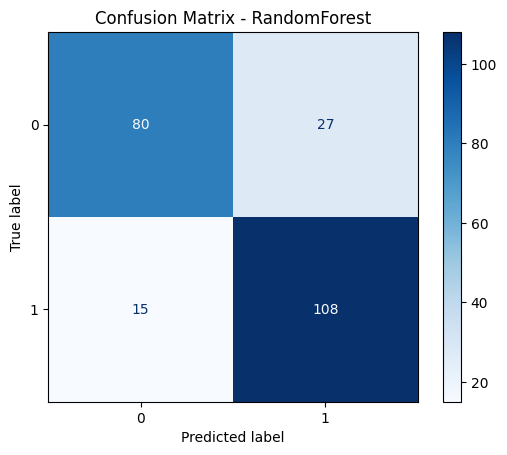

In [38]:
y_pred = RandomForestClassifierModel.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - RandomForest")
plt.show()

To show **ROC Curve & AUC Score**

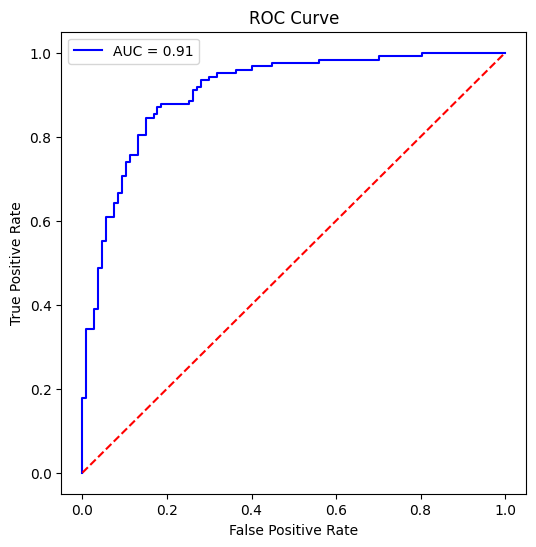

In [39]:
y_prob = RandomForestClassifierModel.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

We make **GridSearchCV** to chosen best parameters for **RandomForestClassifier**

Parameters after make **GridSearchCV** to **RandomForestClassifier** for best Model:

In [40]:
# Model with best params
best_Random_Forest = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=5,
    criterion='gini',
    random_state=33)

# Training
best_Random_Forest.fit(X_train, y_train)

# Evaluation
print("Train Score:", best_Random_Forest.score(X_train, y_train))
print("Test Score:", best_Random_Forest.score(X_test, y_test))
print("----------------------------------------------------")

# Prediction
y_pred = best_Random_Forest.predict(X_test)
y_pred_prob = best_Random_Forest.predict_proba(X_test)[:, 1]

Train Score: 0.9651162790697675
Test Score: 0.8652173913043478
----------------------------------------------------


So we use **best estimator** on Test set:

In [41]:
print("Classification Report:")
print(classification_report(y_test, y_pred))
print('Feature Importances:', best_Random_Forest.feature_importances_)

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       107
           1       0.86      0.89      0.88       123

    accuracy                           0.87       230
   macro avg       0.87      0.86      0.86       230
weighted avg       0.87      0.87      0.86       230

Feature Importances: [0.0678376  0.0414774  0.05555303 0.06391672 0.03408481 0.10478425
 0.08588169 0.10815446 0.05401757 0.03999381 0.00935873 0.01259365
 0.00701331 0.14615544 0.16917754]


Model after chosen best estamators **Evaluation**

Visualization by **Confusion Matrix** after chosen best estmators:

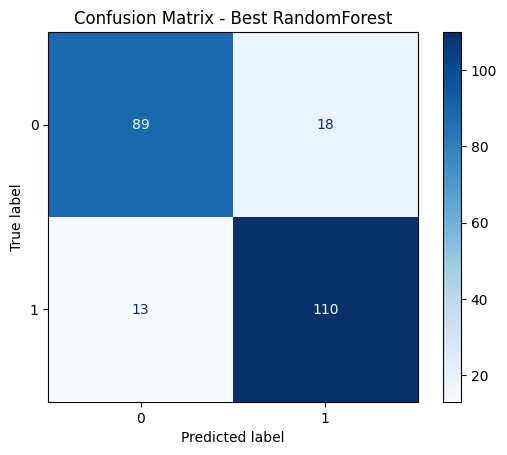

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best RandomForest")
plt.show()

Visualization by **ROC Curve** after chosen best estmators:

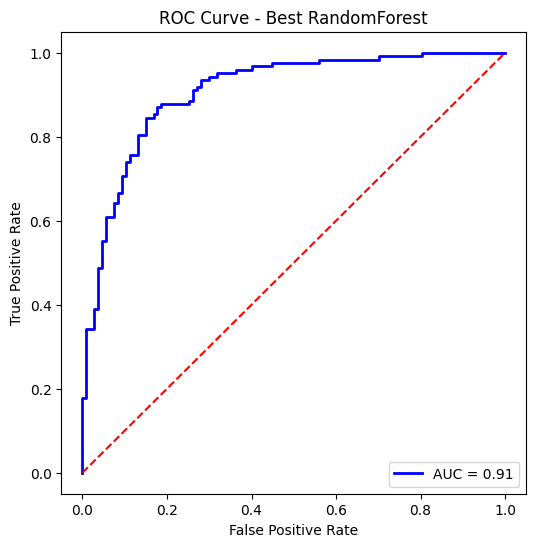

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best RandomForest")
plt.legend(loc="lower right")
plt.show()

Visualization for Important features which affected on prediction:

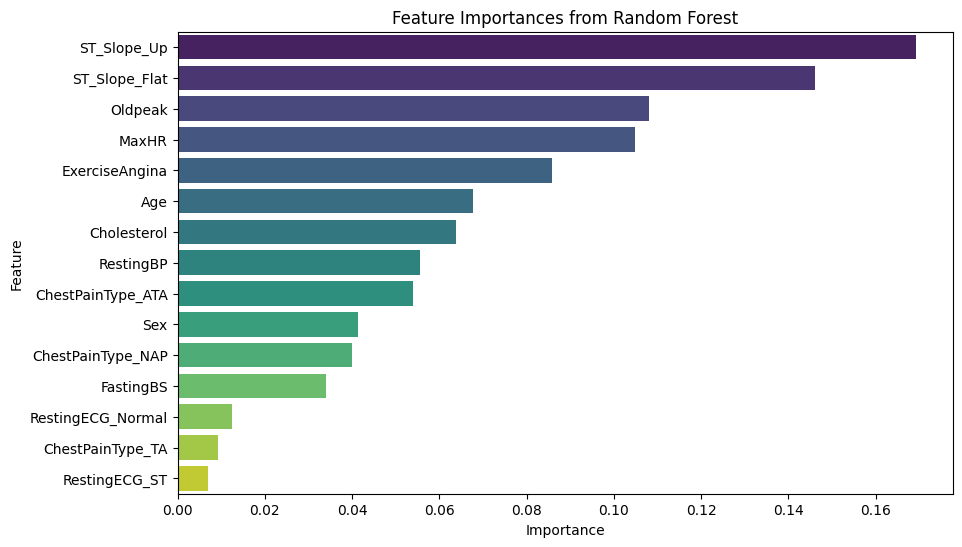

In [44]:
importances = best_Random_Forest.feature_importances_

feature_importances = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": importances}).sort_values(by="Importance", ascending=False)

# barplot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feature_importances, palette="viridis")
plt.title("Feature Importances from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

We Applying  **xgboost** Model

In [45]:
# Model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric="logloss")    # To avoid  warnings

# Training Model
xgb_model.fit(X_train, y_train)

# Prediction
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:,1]

### **Model Evaluation**

To evaluate model if predicted values is near to real values:

In [46]:
print("Classification Report (XGBoost):")
print(classification_report(y_test, y_pred))

Classification Report (XGBoost):
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       107
           1       0.84      0.87      0.85       123

    accuracy                           0.84       230
   macro avg       0.84      0.84      0.84       230
weighted avg       0.84      0.84      0.84       230



To visualzation by **Confusion Matrix**

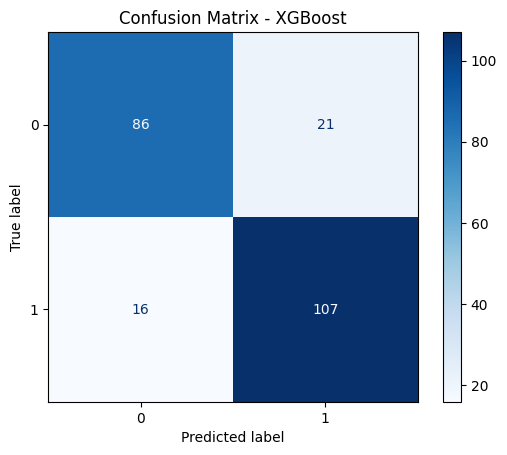

In [47]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()

To visualization by  **ROC Curve**

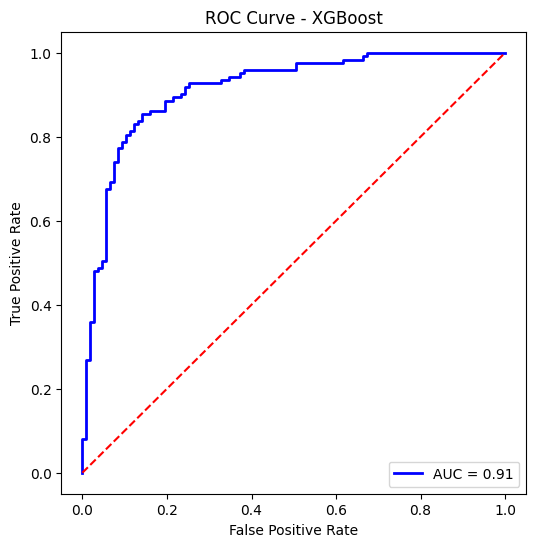

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.show()

We make GridSearchCV to make parameters is best for **XGBoost Model**

Parameters after make GridSearchCV to **XGBoost Model** for best Model:

In [49]:
# Use Model with best parameters
best_params = {
    'subsample': 0.8,
    'n_estimators': 200,
    'min_child_weight': 3,
    'max_depth': None,
    'learning_rate': 0.05,
    'colsample_bytree': 0.6,
    'objective': 'binary:logistic',
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'}

# Model
xgb_best = XGBClassifier(**best_params)

# Training
xgb_best.fit(X_train, y_train)

# Evaluation
y_pred = xgb_best.predict(X_test)
y_proba = xgb_best.predict_proba(X_test)[:,1]

In [50]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8608695652173913
              precision    recall  f1-score   support

           0       0.87      0.82      0.85       107
           1       0.85      0.89      0.87       123

    accuracy                           0.86       230
   macro avg       0.86      0.86      0.86       230
weighted avg       0.86      0.86      0.86       230



To visualize by **Confusion Metrix** after chosen best estmators:

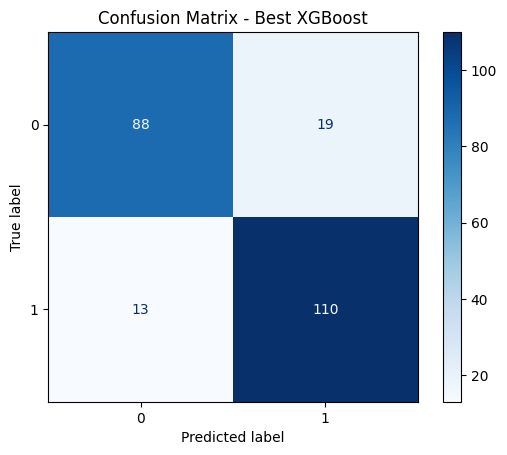

In [51]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Best XGBoost")
plt.show()

To visualize by **ROC Curve** after chosen best estmators:

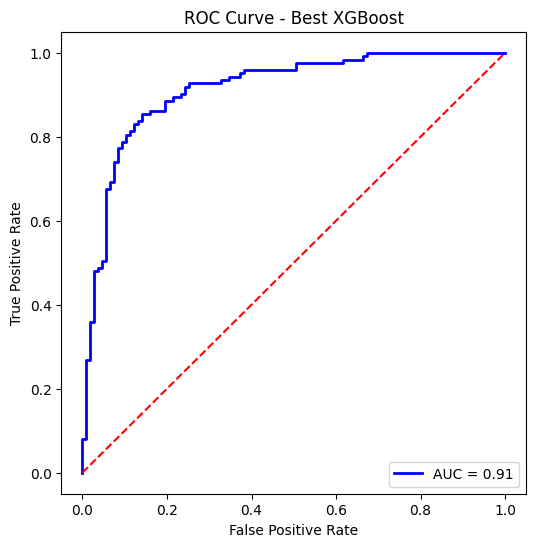

In [52]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Best XGBoost")
plt.legend(loc="lower right")
plt.show()

We use **Stacking Ensemble Classifier (RF + XGBoost + LightGBM + CatBoost) Model**

### **Evaluation Model**

In [53]:
# Base models
base_models = [
    ('rf', RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=5,
        criterion='gini',
        random_state=33
    )),
    ('xgb', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )),
    ('lgbm', LGBMClassifier(
        n_estimators=200,
        max_depth=6,            
        min_child_samples=5,   
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbose=-1           
    )),
    ('cat', CatBoostClassifier(
        iterations=300,
        learning_rate=0.05,
        depth=6,
        random_state=42,
        verbose=0     
    ))
]

# Meta-model
meta_model = LogisticRegression(max_iter=1000)

# Stacking Classifier
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# Training
stack_model.fit(X_train, y_train)

# Prediction
y_pred = stack_model.predict(X_test)


In [54]:
# Evaluation
print("Classification Report (Stacking with RF + XGB + LGBM + CatBoost):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Classification Report (Stacking with RF + XGB + LGBM + CatBoost):
Accuracy: 0.8652173913043478
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       107
           1       0.86      0.89      0.88       123

    accuracy                           0.87       230
   macro avg       0.87      0.86      0.86       230
weighted avg       0.87      0.87      0.86       230



To visualize by **Confusion Metrix**:

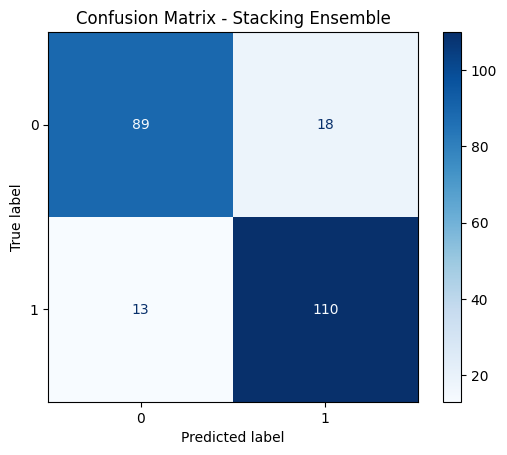

In [55]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Stacking Ensemble")
plt.show()

To visualize by **ROC Curve**:

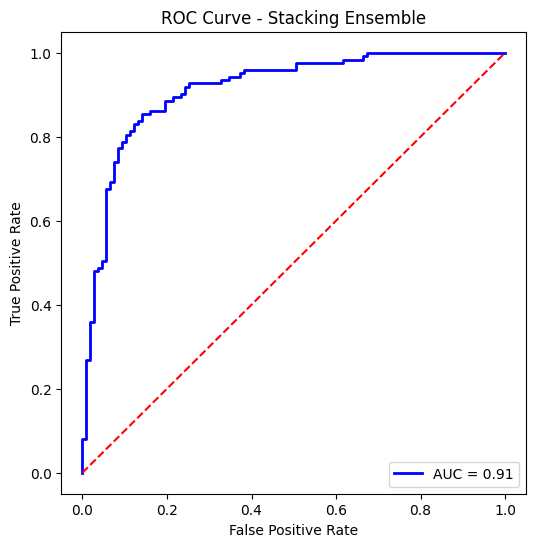

In [56]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking Ensemble")
plt.legend(loc="lower right")
plt.show()

## **Conclusion**

**Random Forest (RF)**

Accuracy: ~87%

F1-score: Balanced across low-risk and high-risk classes

Advantages: Easy to interpret, clear feature importances, good overall performance

Disadvantages: Slightly less flexible than gradient boosting methods

**XGBoost (XGB)**

Accuracy: ~86.5%

F1-score: High for high-risk class, slightly lower for low-risk

Advantages: Excellent control over overfitting, strong performance, robust for imbalanced data

Disadvantages: Less interpretable than RF, requires careful hyperparameter tuning

**Stacking Ensemble (RF + XGB + LGBM + CatBoost)**

Accuracy: ~87%

F1-score: Highest for high-risk class, balanced for low-risk class

Advantages: Best overall performance, reduces errors of individual models, stable predictions

Disadvantages: More complex, less interpretable than single models

**Recommendation**

For highest predictive performance and reliable detection of high-risk patients:
Stacking Ensemble → best balance and recall for high-risk cases.

For interpretability and understanding key risk factors:
Random Forest or XGBoost → easier to analyze feature importance.

**Practical takeaway:**

Use Stacking Ensemble if the goal is accurate heart disease risk prediction.

Use Random Forest/XGBoost if the goal is clinical insights and interpretability.